# Using regression to predict the burned area of forest fires in the northeast region of Portugal

# Introduction
A wildfire is an uncontrolled fire that starts in the wildland vegetation and spreads quickly through the landscape, particularly in rural locations. For hundreds of millions of years, wildfires have burned in forests, grasslands, savannas, and other habitats. They are not constrained by geography or climate. A natural occurrence, such as a lightning strike, or a human-made spark can ignite a wildfire. However, the extent to which a wildfire spreads is frequently determined by weather conditions. Wind, heat, and a lack of rain may dry out trees, bushes, fallen leaves, and limbs, making them excellent fuel for a fire. Topography also plays a role: flames burn faster uphill than they do downhill.

While wildfires are necessary and beneficial to many plants and animals, climate change has made some ecosystems more vulnerable to fires. Drought has worsened as a result of rising temperatures, and forests have dried up. The ancient practice of extinguishing all fires has resulted in an unnatural accumulation of plants and trash, which can feed larger and more violent fires. The size of wildfire burned areas has been unparalleled in recent years, particularly in forested regions around the world, which are increasingly affecting large populations. This emphasizes the critical need to increase our ability to predict and better understand the factors that influence total burned areas in specific conditions, as well as real-time wildfire spread modeling.

The rate at which a wildfire spreads is influenced by a variety of factors, including wind speeds and directions, resulting in complicated nonlinear interactions. The spread rate of wildfires is influenced by the condition of the fuel bed (McAllister, 2019) and its geometry (McAllister and Finney, 2016). Similarly, the nature of firebrands (Hedayati et al., 2019) and the wind-driven transportation of firebrands (Caton-Kerr et al., 2019; Tohidi and Kaye, 2017; Manzello and Suzuki, 2017) influence how wildfires start and spread in specific places.

This project aims to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data.

## Dataset Information
In [Cortez and Morais, 2007], the output `area` was first transformed with a $\ln(x+1)$ function. Then, several Data Mining methods were applied. After fitting the models, the outputs were post-processed with the inverse of the $\ln(x+1)$ transform.

Following are the attributes used in this dataset:
- `X` : x-axis spatial coordinate within the Montesinho park map: 1 to 9
- `Y` : y-axis spatial coordinate within the Montesinho park map: 2 to 9
- `month` : month of the year: 'jan' to 'dec'
- `day` : day of the week: 'mon' to 'sun'
- `FFMC`: FFMC index from the FWI system: 18.7 to 96.20
- `DMC`: DMC index from the FWI system: 1.1 to 291.3
- `DC`: DC index from the FWI system: 7.9 to 860.6
- `ISI`: ISI index from the FWI system: 0.0 to 56.10
- `temp`: temperature in Celsius degrees: 2.2 to 33.30
- `RH`: relative humidity in %: 15.0 to 100
- `wind`: wind speed in km/h: 0.40 to 9.40
- `rain`: outside rain in mm/m2 : 0.0 to 6.4
- `area`: the burned area of the forest (in ha): 0.00 to 1090.84

# Methods and Results

### Exploratory Data Analysis

First, we load and tidy the data by removing the non-numeric columns, `month` and `date`, and the numeric columns, `X` (x-axis coordinates) and `Y` (y-axis coordinates), as they are not relevant in our analysis.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(tidymodels)
    library(projectPackage)
    library(GGally)})

options(repr.plot.width = 15, repr.plot.height = 12)

In [2]:
fire_data <- read_csv("../data/forestfires.csv", show_col_types = FALSE)
fire_data <- data_cleaning(fire_data, c('X','Y','month','day'))
"Table 1: Tidied Data"
head(fire_data)

[1] "Table 1: Tidied Data"

FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Now, we split the data into a 75:25 training and testing split, which is then scaled and centered to ensure that all variables are on a comparable scale.

In [3]:
set.seed(2022)
fire_split <- initial_split(fire_data, prop = 0.75, strata = area)
fire_train <- training(fire_split)
fire_test <- testing(fire_split)

fire_recipe <- recipe_scale_center(fire_train, area ~ .)

fire_scaled <- fire_recipe %>%
            prep() %>%
            bake(fire_train)

Then, we plot a correlation matrix to determine if any pairs of variables are associated with each other.

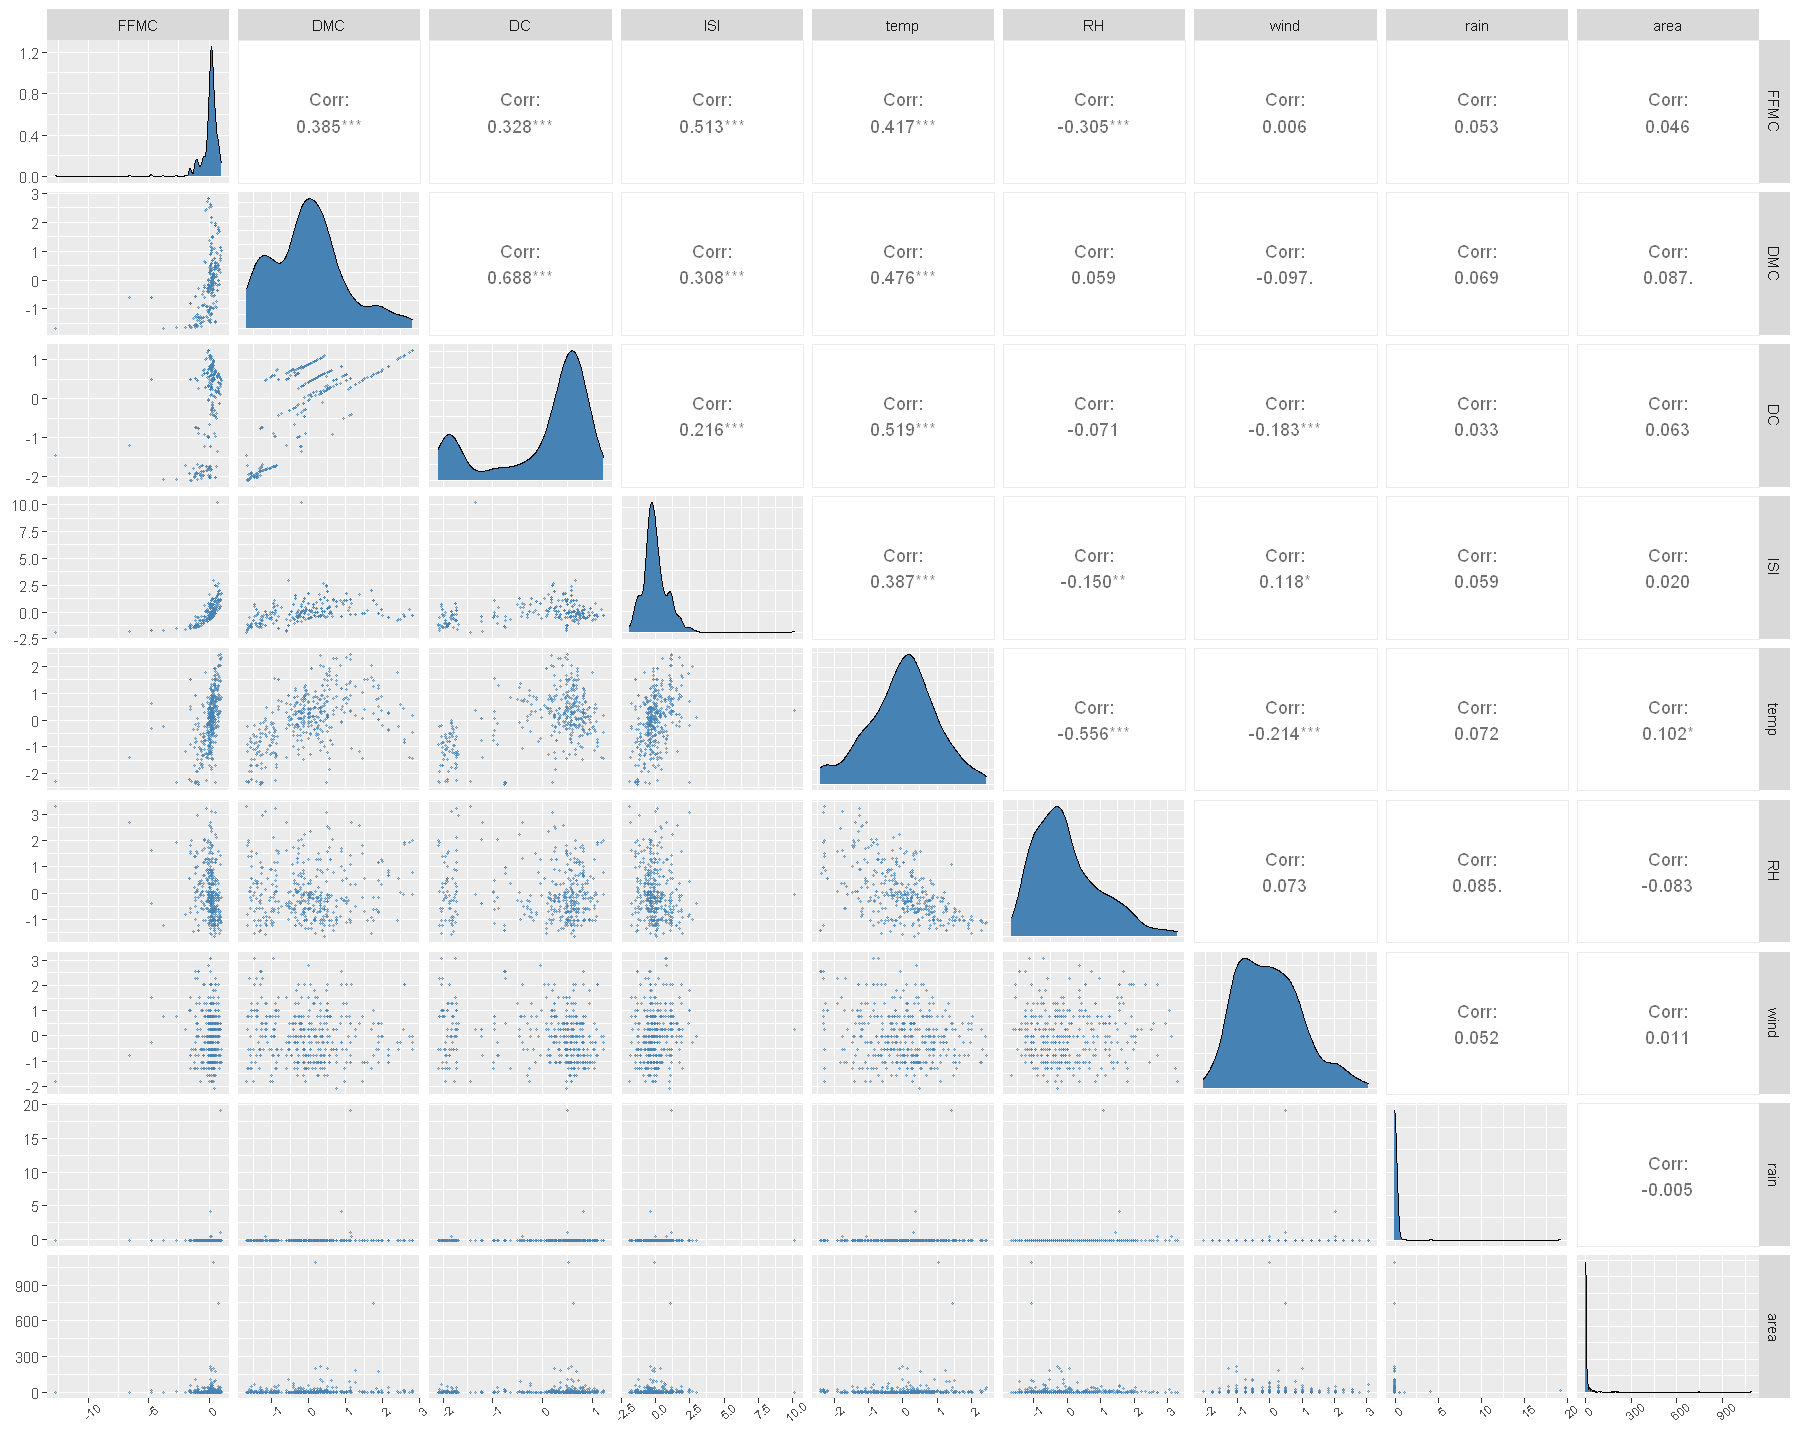

In [5]:
correlation_graph(fire_scaled)

From Figure 1, we see that `DC` and `DMC`; `ISI` and `FFMC`; `temp` and `DMC`; `temp` and `DC`; and `RH` and `temp` have quite large correlation values. So, we will create another correlation matrix with only those variables to examine them closer.

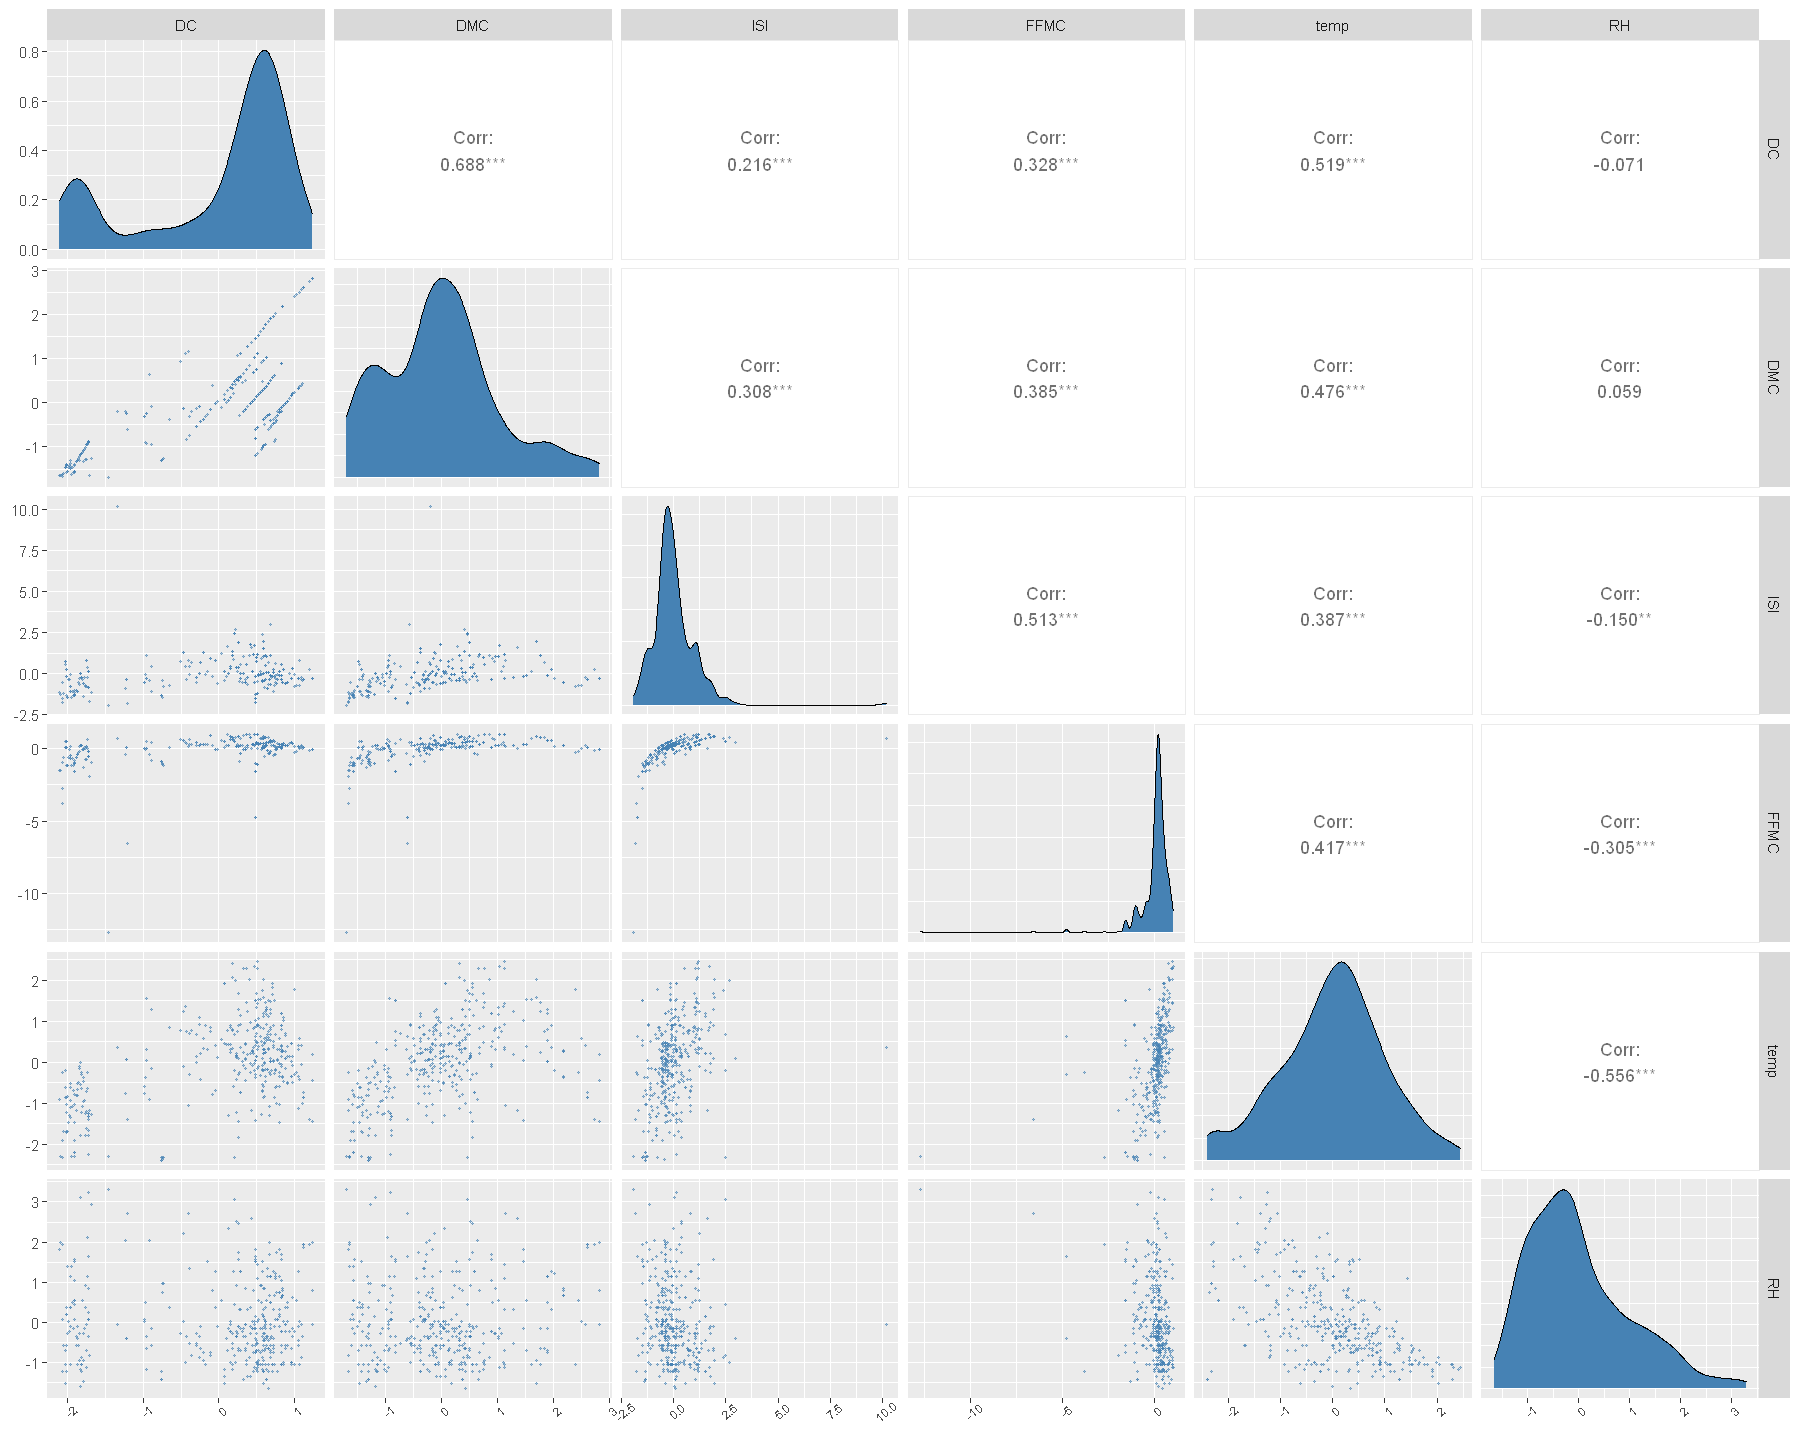

In [7]:
cor_data <- fire_scaled %>% select(DC, DMC, ISI, FFMC, temp, RH)

correlation_graph(cor_data)

Looking at the scatter plots with evident trends, for `DC` and `DMC`, there appears to be a strong, positive relationship between the variables; whereas for temperature (`temp`) and relative humidity (`RH`), there appears to be a weak, negative relationship. And for `ISI` and `FFMC`, the plot follows a logarithmic curve, with a majority of the points concentrated around `ISI` values of -1.25 to 1.25.

### Finding the Best $k$

In order to build our $k$-NN regression model, we use the aforementioned variables and perform cross-validation with 5 folds to find the number of neighbours with the minimum RMSE (root mean square error).

In [8]:
fire_recipe <- recipe_scale_center(fire_train, area ~ DC + DMC + ISI + FFMC + temp + RH)

fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("regression")

fire_cv <- vfold_cv(fire_train, v = 5, strata = area)

fire_wkflw <- workflow() %>%
            add_recipe(fire_recipe) %>%
            add_model(fire_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 200, by = 3))

fire_results <- fire_wkflw %>%
            tune_grid(resamples = fire_cv, grid = gridvals) %>%
            collect_metrics() %>%
            filter(.metric == "rmse")

min_rmse <- fire_results %>%
            filter(mean == min(mean))

k_min <- min_rmse %>%
        pull(neighbors)

"Table 2: The Number of Neighbors with the Minimum RMSE"
min_rmse

[1] "Table 2: The Number of Neighbors with the Minimum RMSE"

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
142,rmse,standard,59.01036,5,19.70003,Preprocessor1_Model48


We see that the smallest RMSE is when $k=142$. So, we will use $k=142$ when we retrain our model.

### Evaluating on the Test Set

To see how well our model predicts on unknown data, we will retrain it to use $k=142$ neighbours before predicting on the test set.

In [9]:
test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
            set_engine("kknn") %>%
            set_mode("regression")

fire_fit <- workflow() %>%
            add_recipe(fire_recipe) %>%
            add_model(test_spec) %>%
            fit(data = fire_train)

fire_summary <- fire_fit %>%
                predict(fire_test) %>%
                bind_cols(fire_test) %>%
                metrics(truth = area, estimate = .pred) %>%
                filter(.metric == "rmse")

"Table 3: Testing RMSE"
fire_summary

[1] "Table 3: Testing RMSE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,30.93697


The new model's RMSE is 30.94 ha, which is the burned area of the forest. When comparing the test model's RMSE to the training model's RMSE of 59.01 ha, we get a difference of 28.07 ha. Because the difference is quite large, our model does a adequate job at generalizing to new data.

# Discussion

From Figure 1, we can see that the response variable (area) has almost no correlation with the other explanatory variables. This result was unexpected since we thought environmental factors, such as rain, temperature, wind, etc., would have a significant impact on the burned area, whether positive or negative. After further investigation, we noticed that there are many zeros in the dataset in the response column. The large number of zeros has made our data analysis less interpretable and revealing. As most of our output is skewed towards zero, the patterns of the graphs became counter-intuitive and the correlation indexes are also heavily influenced. One remedy is to apply a transformation to the response to yield better linearity, more stabilized variance and a more conspicuous relationship between the variables. 

Furthermore, the skewed nature of our dataset is what prompted us to adopt $k$-NN regression. A multiple linear regression (MLR) model places more constraints on the data, such as low multicollinearity, linearity, non-constant variance etc., and we discovered that our data fall well short of those requirements. For instance, from Figure 2 we can see that many of our explanatory variables are highly correlated with each other and hence the assumption of no or low multicollinearity fails. $k$-NN regression, on the other hand, performs well with non-linear relationships since it requires fewer assumptions about the data distribution, making it a better fit for this project than MLR.

Finally, the devastating effects of forest fires speak for themselves. It has led to the irreversible loss of countless properties, crops, animals and people. In this analysis, we wish to predict the burned area of forests based on several environmental factors. By establishing a transparent link between them, it is possible to identify potential risk factors and take appropriate safeguards to prevent the emergence of forest fires and the disasters they generate. Moreover, our analysis can lead to many future research questions such as:

- When are forest fires most likely to occur?
- Are forest fires more likely to be caused artificially or naturally? 
- What is the average financial damage of a forest fire?

# References


[Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. Available at https://archive.ics.uci.edu/ml/datasets/forest+fires

Wood, D. A. (2021, January 16). Prediction and data mining of burned areas of forest fires: Optimized data matching and mining algorithm provides valuable insight. Artificial Intelligence in Agriculture. Retrieved February 17, 2022, from https://www.sciencedirect.com/science/article/pii/S2589721721000118 

NWCG Members. (2021, July 8). Fire weather index (FWI) system. NWCG. Retrieved February 17, 2022, from https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-system 

Perez, J. (2017, July 21). Causes et consequences of forest fires. OMPE. Retrieved February 17, 2022, from https://www.ompe.org/en/causes-et-consequences-of-forest-fires/ 